# Decentmon data preparation

In [1]:
import pandas as pd

from decmon.constants import *
from decmon.df_utils import *
from decmon.filter import *
from decmon.plotter import *

In [2]:
SUBDIR = "5"

In [3]:
path = f"{INPUT_DIR}/{SUBDIR}"

f_df = [load_simulation_data(f"{path}/{i}_output.log") for i in PATTERNS]
f_df[0].head()

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,0,1,2,3,2,5,0,0,1.0,0.00,0.0,3,5,3,"Next (Var ""b"")",{ |b| | | } ; {a|b| |d|e} ; {a|b|c| |e} ; {a|...
1,1,1,2,3,2,5,4,0,1.0,2.00,0.0,4,6,4,"Ev (Var ""e"")",{ | | |d| } ; { |b| | |e} ; { | |c| |e} ; { |...
2,2,1,3,4,3,10,4,0,1.0,1.33,0.0,6,12,6,"Ev (Var ""a"")",{ |b|c|d| } ; { | |c|d| } ; {a| |c| | } ; { |...
3,3,1,2,3,2,5,0,0,1.0,0.00,0.0,3,5,3,"Next (Var ""b"")",{a| |c| |e} ; {a| |c| |e} ; {a|b|c| | } ; { |...
4,4,1,2,3,2,5,0,0,1.0,0.00,0.0,3,5,3,"Next (Var ""c"")",{a|b|c| | } ; {a|b|c| |e} ; { |b|c|d| } ; { |...


In [4]:
strategies_f_df = [split_by_dictionary(f_df[i], STRATEGIES) for i in PATTERNS]

print(f"Datasets: {len(strategies_f_df)}. Strategies: {len(strategies_f_df[0])}. Single dataset Formulae:{len(strategies_f_df[0][0])}")
sep_strat_f_df = [pd.concat(strategies_f_df[i], ignore_index=True) for i in PATTERNS]
sep_strat_f_df[0].head()

Datasets: 8. Strategies: 3. Single dataset Formulae:4221


,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,0,1,2,5,1.0,3,"Next (Var ""b"")",{ |b| | | } ; {a|b| |d|e} ; {a|b|c| |e} ; {a|...,orchestration
1,1,1,2,5,1.0,4,"Ev (Var ""e"")",{ | | |d| } ; { |b| | |e} ; { | |c| |e} ; { |...,orchestration
2,2,1,3,10,1.0,6,"Ev (Var ""a"")",{ |b|c|d| } ; { | |c|d| } ; {a| |c| | } ; { |...,orchestration
3,3,1,2,5,1.0,3,"Next (Var ""b"")",{a| |c| |e} ; {a| |c| |e} ; {a|b|c| | } ; { |...,orchestration
4,4,1,2,5,1.0,3,"Next (Var ""c"")",{a|b|c| | } ; {a|b|c| |e} ; { |b|c|d| } ; { |...,orchestration


In [5]:
merged_metrics_df = [extract_metrics(sep_strat_f_df[i]) for i in PATTERNS]
merged_metrics_df[0].max()

formula_id             4220
strategy      orchestration
value               52840.0
metric            trace_len
dtype: object

## Formula Encoding

In [6]:
df_f_ops = [extract_ops(sep_strat_f_df[i])[0] for i in PATTERNS]
df_f_ops[0].head()

0    11
1    12
2    12
3    11
4    11
Name: 0, dtype: int64

## Plotting

In [7]:
# for i in PATTERNS:
#     grid_plot = plot_grid_barplots(merged_metrics_df[i],
#               grid_cell_field= 'metric',
#               y_axis = 'value', x_axis = 'strategy',
#               order = ['orchestration', 'migration', 'choreography'])

#grid_plot.savefig("output/out.png")

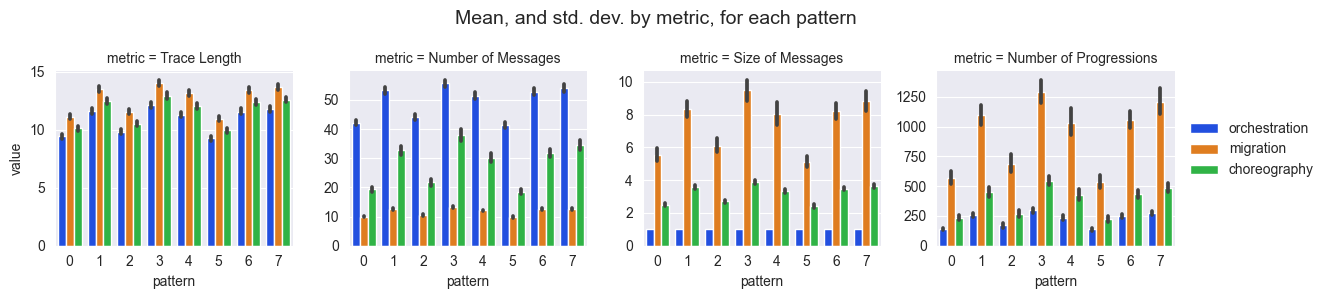

In [11]:
merged_metrics_dfp = prepare_with_pattern(merged_metrics_df)
plot = plot_metrics_by_patterns(merged_metrics_dfp)
plot.savefig(f"output/pattern_{SUBDIR}.png")
plot

In [9]:
expanded_f_df = [sep_strat_f_df[i].merge(df_f_ops[i], left_index=True, right_index=True) for i in PATTERNS]
expanded_f_df[0].head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0
0,0,1,2,5,1.0,3,"Next (Var ""b"")",{ |b| | | } ; {a|b| |d|e} ; {a|b|c| |e} ; {a|...,orchestration,11
1,1,1,2,5,1.0,4,"Ev (Var ""e"")",{ | | |d| } ; { |b| | |e} ; { | |c| |e} ; { |...,orchestration,12
2,2,1,3,10,1.0,6,"Ev (Var ""a"")",{ |b|c|d| } ; { | |c|d| } ; {a| |c| | } ; { |...,orchestration,12
3,3,1,2,5,1.0,3,"Next (Var ""b"")",{a| |c| |e} ; {a| |c| |e} ; {a|b|c| | } ; { |...,orchestration,11
4,4,1,2,5,1.0,3,"Next (Var ""c"")",{a|b|c| | } ; {a|b|c| |e} ; { |b|c|d| } ; { |...,orchestration,11


In [10]:
for i in PATTERNS:
    expanded_f_df[i].strategy = pd.Categorical(expanded_f_df[i].strategy)
    expanded_f_df[i]['strategy_id'] = expanded_f_df[i].strategy.cat.codes

full_scale_df_5 = pd.concat(expanded_f_df)
full_scale_df_5.head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,strategy_id
0,0,1,2,5,1.0,3,"Next (Var ""b"")",{ |b| | | } ; {a|b| |d|e} ; {a|b|c| |e} ; {a|...,orchestration,11,2
1,1,1,2,5,1.0,4,"Ev (Var ""e"")",{ | | |d| } ; { |b| | |e} ; { | |c| |e} ; { |...,orchestration,12,2
2,2,1,3,10,1.0,6,"Ev (Var ""a"")",{ |b|c|d| } ; { | |c|d| } ; {a| |c| | } ; { |...,orchestration,12,2
3,3,1,2,5,1.0,3,"Next (Var ""b"")",{a| |c| |e} ; {a| |c| |e} ; {a|b|c| | } ; { |...,orchestration,11,2
4,4,1,2,5,1.0,3,"Next (Var ""c"")",{a|b|c| | } ; {a|b|c| |e} ; { |b|c|d| } ; { |...,orchestration,11,2
